### MATCH DEEP FIELD OBJECTS TO BALROG DETECTION FILE ###
To make sure the ID is the same

In [2]:
import numpy as np
import fitsio as fio
import pylab as plt
import pandas as pd
import astropy.table

In [3]:
#balrog Y3 detetcion file and deep field ra,dec file

balrog_detection_file = "/global/cfs/cdirs/des/severett/Balrog/run2a/stacked_catalogs/1.4/sof/balrog_detection_catalog_sof_run2a_v1.4.fits"
deep_field_file = "/pscratch/sd/j/jelvinpo/DES/cats/y3/deepfields/Y3_DEEP_FIELDS_PHOTOM_ang_mag.fits"
deep_field_sg_file = "/pscratch/sd/j/jelvinpo/DES/cats/y3/deepfields/Y3_DEEP_FIELDS_PHOTOM_ang_mag_sg.fits"
deep_field_wise_file = "/global/cfs/projectdirs/des/nweaverd/y3_deepfields/dr10.0/south/matched/merged_ls-dr10.0-Y3_DEEP_FIELDS_PHOTOM_ang_mag.fits"


In [45]:
balrog_detection_table = astropy.table.Table.read(balrog_detection_file)
#balrog_detection = balrog_detection_table[['true_id']].to_pandas()
data = np.array([
    balrog_detection_table['true_id'],
    balrog_detection_table["true_bdf_mag_deredden"][:,0],
    balrog_detection_table["true_bdf_mag_deredden"][:,1],
    balrog_detection_table["true_bdf_mag_deredden"][:,2],
    balrog_detection_table["true_bdf_mag_deredden"][:,3],
])
columns = [
    'true_id', 
    'true_bdf_mag_deredden_g',
    'true_bdf_mag_deredden_r',
    'true_bdf_mag_deredden_i',
    'true_bdf_mag_deredden_z' ]
balrog_detection = pd.DataFrame(data=data.T, columns=columns)
deep_field = astropy.table.Table.read(deep_field_file).to_pandas()
deep_field_sg = astropy.table.Table.read(deep_field_sg_file).to_pandas()



In [46]:
balrog_detection_with_deepcoord = balrog_detection.merge(deep_field, how='inner', left_on='true_id', right_on='ID')


In [47]:
x0 = np.array(balrog_detection_with_deepcoord['BDF_MAG_DERED_G'] )
x1 = np.array(balrog_detection_with_deepcoord['BDF_MAG_DERED_CALIB_G'] )
y =  np.array(balrog_detection_with_deepcoord['true_bdf_mag_deredden_g'] )

Text(0.5, 1.0, 'Difference in magnitude between official deep field \nand balrog injection catalog in y3')

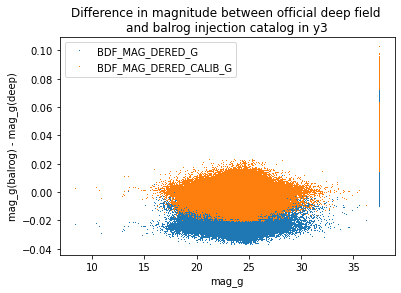

In [48]:
plt.plot(x0,y-x1,',', label='BDF_MAG_DERED_G')
plt.plot(x0,y-x0,',', label='BDF_MAG_DERED_CALIB_G')
plt.xlabel('mag_g')
plt.ylabel('mag_g(balrog) - mag_g(deep)')
plt.legend()
plt.title('Difference in magnitude between official deep field \nand balrog injection catalog in y3')


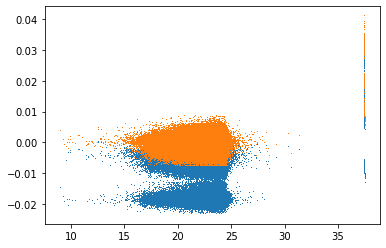

In [50]:
x0 = np.array(balrog_detection_with_deepcoord['BDF_MAG_DERED_Z'])
x1 = np.array(balrog_detection_with_deepcoord['BDF_MAG_DERED_CALIB_Z'])
y =  np.array(balrog_detection_with_deepcoord['true_bdf_mag_deredden_z'] )
plt.plot(x0,y-x1,',')
plt.plot(x0,y-x0,',')

In [51]:
print(np.std((y-x0)))
print(np.std((y-x0)[(x0 > 20)*(x0 < 25)]))

0.0019187017712872757
0.001761720835122575


### ADD N_INJECTION N_DETECTIONS TO WISE MATCHED DEEP FIELDS###
+make plot showing fraction of matches vs magnitude

In [52]:
#load the matched deep field catalog + balrog detections

balrog_detection_table = astropy.table.Table.read(balrog_detection_file)
deep_field = astropy.table.Table.read(deep_field_file)
deep_field_wise = astropy.table.Table.read(deep_field_wise_file)

In [53]:
#count number of times each deep field object was injected/detected
import collections
count_inj = collections.Counter(balrog_detection_table['true_id'])
count_det = collections.Counter(balrog_detection_table['true_id'][balrog_detection_table['detected'] == 1])
injected_id = np.unique(balrog_detection_table["true_id"]).data

#n_injections = np.array([count_inj[i] for i in injected_id])
#n_detections = np.array([count_det[i] for i in injected_id])


In [58]:
#match injected id list to the matched deep fieled catalog
injected_id_pd = astropy.table.Table(data=[injected_id], names=['INJ_ID']).to_pandas()
injected_id_merged = injected_id_pd.merge(deep_field_wise[['ID','FLUX_W1','BDF_MAG_DERED_I','RA_1','DEC_1']].to_pandas(), how='inner', left_on='INJ_ID', right_on='ID')
injected_flux_W1 = np.array(injected_id_merged['FLUX_W1'])
injected_imag = np.array(injected_id_merged['BDF_MAG_DERED_I'])

In [59]:
#select matches/positive matches
has_wise_match = ~np.isnan(injected_flux_W1)
has_pos_wise_match = injected_flux_W1 > 0.

In [62]:
n_injections = np.array([count_inj[i] for i in injected_id_merged['INJ_ID'] ])
n_detections = np.array([count_det[i] for i in injected_id_merged['INJ_ID'] ])

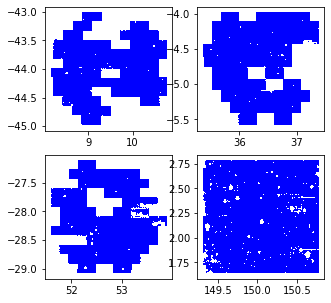

In [63]:
#plot deep field ra/dec
ra  = np.array(injected_id_merged['RA_1'])
dec = np.array(injected_id_merged['DEC_1'])

fig, axs = plt.subplots(2,2,figsize=(5,5))
axs = axs.flatten()
select1 = (ra < 20)
select2 = (ra < 60)*(dec > -10)
select3 = (ra > 40)*(dec < -20)
select4 = (ra > 120)
select = [select1, select2, select3, select4,]
for i in range(4):
    axs[i].plot(ra[select[i]], dec[select[i]], ',', color='blue')

In [64]:
#get total fractions

frac_injections_with_wise_match = np.sum(n_injections[has_wise_match])/np.sum(n_injections)
frac_detections_with_wise_match = np.sum(n_detections[has_wise_match])/np.sum(n_detections)

frac_injections_with_pos_wise_match = np.sum(n_injections[has_pos_wise_match])/np.sum(n_injections)
frac_detections_with_pos_wise_match = np.sum(n_detections[has_pos_wise_match])/np.sum(n_detections)

print("frac Y3 injections with deep-field WISE match =", frac_injections_with_wise_match)
print("frac Y3 detections with deep-field WISE match =", frac_detections_with_wise_match)

print("frac Y3 injections with positive-flux deep-field WISE match =", frac_injections_with_pos_wise_match)
print("frac Y3 detections with positive-flux deep-field WISE match =", frac_detections_with_pos_wise_match)


frac Y3 injections with deep-field WISE match = 1.0
frac Y3 detections with deep-field WISE match = 1.0
frac Y3 injections with positive-flux deep-field WISE match = 0.7338203870626919
frac Y3 detections with positive-flux deep-field WISE match = 0.7977141055926499


In [65]:
#get fractions as a function of true i-band magnitude

ilim_list = np.linspace(22, 25, 10)
frac_injections_with_wise_match = np.array([])
frac_detections_with_wise_match = np.array([])
frac_injections_with_pos_wise_match = np.array([])
frac_detections_with_pos_wise_match = np.array([])
for ilim in ilim_list:
    select_ilim = (injected_imag < ilim)
    
    frac_injections_with_wise_match_1 = np.sum(n_injections[select_ilim*has_wise_match])/np.sum(n_injections[select_ilim])
    frac_detections_with_wise_match_1 = np.sum(n_detections[select_ilim*has_wise_match])/np.sum(n_detections[select_ilim])

    frac_injections_with_pos_wise_match_1 = np.sum(n_injections[select_ilim*has_pos_wise_match])/np.sum(n_injections[select_ilim])
    frac_detections_with_pos_wise_match_1 = np.sum(n_detections[select_ilim*has_pos_wise_match])/np.sum(n_detections[select_ilim])

    frac_injections_with_wise_match = np.append(frac_injections_with_wise_match, frac_injections_with_wise_match_1)
    frac_detections_with_wise_match = np.append(frac_detections_with_wise_match, frac_detections_with_wise_match_1)
    frac_injections_with_pos_wise_match = np.append(frac_injections_with_pos_wise_match, frac_injections_with_pos_wise_match_1)
    frac_detections_with_pos_wise_match = np.append(frac_detections_with_pos_wise_match, frac_detections_with_pos_wise_match_1)


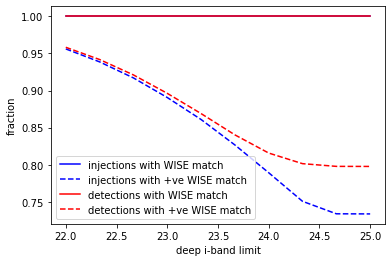

In [66]:
plt.plot(ilim_list, frac_injections_with_wise_match, '-', color='b', label='injections with WISE match')
plt.plot(ilim_list, frac_injections_with_pos_wise_match, '--', color='b', label='injections with +ve WISE match')

plt.plot(ilim_list, frac_detections_with_wise_match, '-', color='r', label='detections with WISE match')
plt.plot(ilim_list, frac_detections_with_pos_wise_match, '--', color='r', label='detections with +ve WISE match')
plt.xlabel('deep i-band limit')
plt.ylabel('fraction')
plt.legend()
plt.savefig('frac_of_injections_with_wise_flux.png')


### What is the fraction of WISE matches for MAGLIM objects?###

In [69]:
balrog_maglim_file = "/global/cfs/cdirs/des/jelvinpo/cats/y3/balrog/run2/lens_samples_run2_v1.4/maglim_lens_v2p2_flux_balrog_run2_v1.4_masked.fits.gz"
balrog_maglim = fio.read(balrog_maglim_file)

y3_maglim_injected_id_pd = astropy.table.Table(data=[
    balrog_maglim["true_id"],
    balrog_maglim['meas_cm_mag_deredden'][:,1],
    balrog_maglim['meas_cm_mag_deredden'][:,3],
    balrog_maglim['Z_MEAN'],
    balrog_maglim['true_bdf_T'],
    balrog_maglim['true_bdf_T_err'],
    ],
    names=[
        'INJ_ID',
        'meas_cm_mag_deredden_r',
        'meas_cm_mag_deredden_z',
        'Z_MEAN',
        'true_bdf_T',
        'true_bdf_T_err',
    ],
    ).to_pandas()
y3_maglim_injected_id_merged = y3_maglim_injected_id_pd.merge(deep_field_wise[['ID','FLUX_W1','FLUX_IVAR_W1','BDF_MAG_DERED_I', "W1_MAG_CORR"]].to_pandas(), how='inner', left_on='INJ_ID', right_on='ID')
y3_maglim_injected_id_merged = y3_maglim_injected_id_merged.merge( deep_field_sg[['ID','KNN_CLASS']] , how='inner', left_on='INJ_ID', right_on='ID')
y3_maglim_injected_flux_W1 = np.array(y3_maglim_injected_id_merged['FLUX_W1'])
y3_maglim_injected_flux_S2N = y3_maglim_injected_id_merged["FLUX_W1"]*np.sqrt(y3_maglim_injected_id_merged["FLUX_IVAR_W1"])

y3_maglim_has_wise_match = ~np.isnan(y3_maglim_injected_flux_W1)
y3_maglim_has_pos_wise_match = y3_maglim_injected_flux_W1 > 0.

In [71]:
frac_y3maglim_with_wise_match = np.sum(y3_maglim_has_wise_match.astype('int'))/len(y3_maglim_injected_id_merged)
frac_y3maglim_with_pos_wise_match = np.sum(y3_maglim_has_wise_match.astype('int'))/len(y3_maglim_injected_id_merged)

print("frac Y3 balrog-maglim with deep-field WISE match =", frac_y3maglim_with_wise_match )
print("frac Y3 balrog-maglim with positive-flux deep-field WISE match =", frac_y3maglim_with_pos_wise_match )


frac Y3 balrog-maglim with deep-field WISE match = 1.0
frac Y3 balrog-maglim with positive-flux deep-field WISE match = 1.0


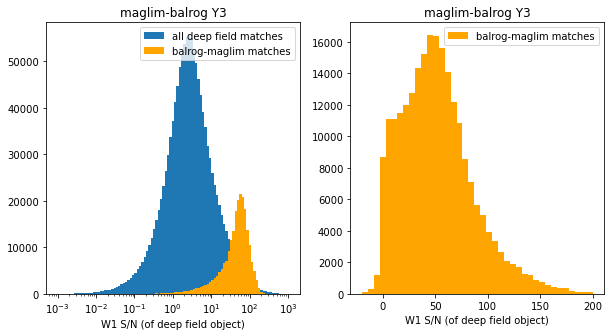

In [72]:
#S/N histogram for matched maglim-balrog
s2n_edges_log = np.logspace(-3,3,100)
s2n_edges_lin = np.linspace(-20,200,40)
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(deep_field_wise["FLUX_W1"]*np.sqrt(deep_field_wise["FLUX_IVAR_W1"]), bins=s2n_edges_log, label='all deep field matches')
axs[0].hist(y3_maglim_injected_flux_S2N, bins=s2n_edges_log, label='balrog-maglim matches', color='orange')
axs[0].set_xlabel('W1 S/N (of deep field object)')
axs[0].set_title('maglim-balrog Y3')
axs[0].semilogx()
axs[0].legend()

axs[1].hist(y3_maglim_injected_flux_S2N, bins=s2n_edges_lin, label='balrog-maglim matches', color='orange' )
axs[1].set_xlabel('W1 S/N (of deep field object)')
axs[1].set_title('maglim-balrog Y3')
axs[1].legend()

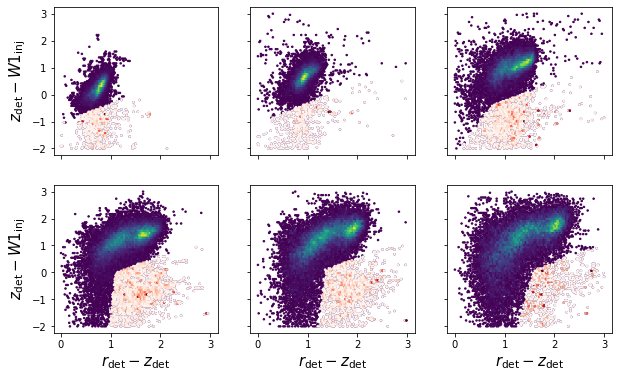

In [73]:
#apply the Y6 WISE cut
zminusw1 = np.array(y3_maglim_injected_id_merged["meas_cm_mag_deredden_z"])-np.array(y3_maglim_injected_id_merged["W1_MAG_CORR"])
rminusz  = np.array(y3_maglim_injected_id_merged["meas_cm_mag_deredden_r"])-np.array(y3_maglim_injected_id_merged["meas_cm_mag_deredden_z"])                                                                                         
z = np.array(y3_maglim_injected_id_merged["Z_MEAN"])
knn = np.array(y3_maglim_injected_id_merged['KNN_CLASS'])

cuts_y6 = [
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 0.8*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 2.5*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.4)*(zminusw1 < 2.5*(rminusz-0.75)-0.4), 
    (zminusw1 < 0.7*(rminusz-1.2)+0  )*(zminusw1 < 3*(rminusz-1.2)+0), 
    (zminusw1 < 0.7*(rminusz-1.4)+0.1)*(zminusw1 < 6*(rminusz-1.4)+0.1), 
    (zminusw1 < 0.7*(rminusz-1.6)+0.1)*(zminusw1 < 6*(rminusz-1.6)+0.1), 
]
cuts_y3 = [
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 0.8*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 0.8*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.4)*(zminusw1 < 2.5*(rminusz-0.75)-0.4), 
    (zminusw1 < 0.7*(rminusz-1.1)+0  )*(zminusw1 < 15*(rminusz-1.1)+0), 
    (zminusw1 < 0.7*(rminusz-1.35)+0.1)*(zminusw1 < 15*(rminusz-1.35)+0.1), 
    (zminusw1 < 0.7*(rminusz-1.6)+0.1)*(zminusw1 < 6*(rminusz-1.6)+0.1), 
]
cuts = cuts_y3

binedges = [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05]
fig,axs = plt.subplots(2,3, figsize=(10,6), sharex=True, sharey=True)
axs = axs.flatten()
for ibin in range(len(binedges)-1):
    selectz = (z > binedges[ibin])*(z < binedges[ibin+1])
    axs[ibin].hexbin(rminusz[selectz],zminusw1[selectz],gridsize=100, extent=[0,3,-2,3],mincnt=1)
    axs[ibin].hexbin(rminusz[selectz*cuts[ibin]],zminusw1[selectz*cuts[ibin]],gridsize=100, extent=[0,3,-2,3],mincnt=1,cmap='Reds')

    if ibin == 0 or ibin == 3:
        axs[ibin].set_ylabel(r'$z_{\rm det} - W1_{\rm inj}$', fontsize=15)
    if ibin >= 3:
        axs[ibin].set_xlabel(r'$r_{\rm det} - z_{\rm det}$', fontsize=15)



0
400
-14.566160079315331 16.5671377602386
nan nan
0
681
-18.086882782742116 16.186011314620554
nan nan
0
1122
-18.508067177224042 16.817496072293523
nan nan
0
1152
-19.565091268288793 18.717009063992016
nan nan
0
1047
-18.27849703176164 18.744189235557194
nan nan
0
1348
-18.396497156346214 19.19021072521081
nan nan


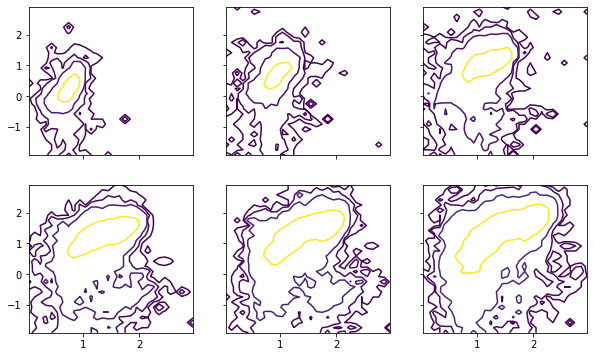

In [76]:
binedges = [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05]
fig,axs = plt.subplots(2,3, figsize=(10,6), sharex=True, sharey=True)
axs = axs.flatten()
for ibin in range(len(binedges)-1):
    selectz = (z > binedges[ibin])*(z < binedges[ibin+1])
    plot_contour(rminusz[selectz], zminusw1[selectz], 
                 quantiles=[.68, .95, .99, .999 ],
                 #quantiles=np.linspace(0.1,0.9,10),
                 bins=30, 
                 ax=axs[ibin], 
                 hist2d_kwargs={'range':[[0,3],[-2,3]]},
                )
    

In [77]:
#fig,axs = plt.subplots(2,3, figsize=(10,6), sharex=True, sharey=True)
#axs = axs.flatten()
print('Fraction of Y3 balrog-maglim objects removed by WISE cut, binned by KNN Star/gal classifier')
print('')
print ("bin", "No_Class", "Galaxy", "Star", "Ambiguous")
for ibin in range(len(binedges)-1):
    selectz = (z > binedges[ibin])*(z < binedges[ibin+1])

    knn_bin_before = knn[selectz]
    knn_bin_after = knn[selectz*~cuts[ibin]]

    nc_before   = np.sum((knn_bin_before == 0).astype(int))
    gal_before  = np.sum((knn_bin_before == 1).astype(int))
    star_before = np.sum((knn_bin_before == 2).astype(int))
    amb_before  = np.sum((knn_bin_before == 3).astype(int))

    nc_after   = np.sum((knn_bin_after == 0).astype(int))
    gal_after  = np.sum((knn_bin_after == 1).astype(int))
    star_after = np.sum((knn_bin_after == 2).astype(int))
    amb_after  = np.sum((knn_bin_after == 3).astype(int))
    
    print(
        str(ibin+1).ljust(3), 
        str(np.round(1-nc_after/nc_before,3)).ljust(8), 
        str(np.round(1-gal_after/gal_before,3)).ljust(6), 
        str(np.round(1-star_after/star_before,3)).ljust(4),
        str(np.round(1-amb_after/amb_before,3)).ljust(9),
        )
    
    

Fraction of Y3 balrog-maglim objects removed by WISE cut, binned by KNN Star/gal classifier

bin No_Class Galaxy Star Ambiguous
1   0.04     0.031  0.63 nan      
2   0.068    0.031  0.713 nan      
3   0.13     0.049  0.85 nan      
4   0.085    0.028  0.881 nan      
5   0.078    0.022  0.851 nan      
6   0.048    0.02   0.651 nan      


/global/u1/j/jelvinpo/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
for ibin in range(len(binedges)-1):
    selectz = (z > binedges[ibin])*(z < binedges[ibin+1])
    
    n_before = np.sum(selectz.astype('int'))
    n_after = np.sum((selectz*~cuts[ibin]).astype('int'))
    print(np.round(1-n_after/n_before,5))

### NOW TRY THE Y6 DF INJECTIONS (SOME CUTS APPLIED vs y3) ###

In [79]:
y6_df_injections_file = "/global/cfs/cdirs/des/y6-balrog/inputs/BALROG_RUN2_DEEP_CAT_FLAG0INVHS1BDFLT254v4_weighted_v2.fits"
y6_df_injections = fio.read(y6_df_injections_file)

y6_injected_id_pd = astropy.table.Table(data=[y6_df_injections['id']], names=['INJ_ID']).to_pandas()
y6_injected_id_merged = y6_injected_id_pd.merge(deep_field_wise[['ID','FLUX_W1','BDF_MAG_DERED_I']].to_pandas(), how='inner', left_on='INJ_ID', right_on='ID')
y6_injected_flux_W1 = np.array(y6_injected_id_merged['FLUX_W1'])



In [80]:
#select matches/positive matches
y6_has_wise_match = ~np.isnan(y6_injected_flux_W1)
y6_has_pos_wise_match = y6_injected_flux_W1 > 0.


In [ ]:
#get total fractions

frac_y6inj_with_wise_match = np.sum(y6_has_wise_match.astype('int'))/len(y6_df_injections)
frac_y6inj_with_pos_wise_match = np.sum(y6_has_pos_wise_match.astype('int'))/len(y6_df_injections)

print("frac Y6 injections with deep-field WISE match =", frac_y6inj_with_wise_match)
print("frac Y6 injections with positive-flux deep-field WISE match =", frac_y6inj_with_pos_wise_match)


In [75]:
#noah;s function 
def get_hist_levels(histarray, quantiles=[.95, .68]):
    """take array of weights or counts, find contour levels that contain fraction corresponding to quantiles (default 68% and 95%).
    Return values at those quantiles, in same units as histarray (e.g. to pass to "levels" arg in plt.contour."""
    countsort = np.sort(histarray, axis=None)[::-1]
    countsum = histarray.sum()
    cdf_sorted = 1.*np.cumsum(countsort)/countsum
    quantiles = np.array(quantiles)
    idx = np.searchsorted(cdf_sorted, quantiles, side="left")
    return countsort[idx]

def plot_contour(xdat, ydat, bins, quantiles=[.68, .95], ax=None, ignore_nan=False, hist2d_kwargs={}, contour_kwargs={}):
    """enter quantiles=None to use levels argument. if ignore_nan=True, then just ignore nan vals"""
    if ax is None:
        f,ax = plt.subplots()
    if ignore_nan:
        mymask = np.isfinite(xdat) * np.isfinite(ydat)
        print(f'Dropping {(~mymask).sum()} non-finite samples ({100*(~mymask).mean():.3f}%)')
        myx = xdat[mymask]
        myy = ydat[mymask]
    else:        
        myx = xdat
        myy = ydat
    print((~np.isfinite(myx)).sum())
    print((~np.isfinite(myy)).sum())
    print(myx.min(), myx.max())
    print(myy.min(), myy.max())
    heatmap, xedges, yedges = np.histogram2d(myx, myy, bins=bins, **hist2d_kwargs)
    xmids = (xedges[1:]  + xedges[:-1])*0.5
    ymids = (yedges[1:]  + yedges[:-1])*0.5 
    xv, yv = np.meshgrid(xmids, ymids)
    if quantiles is not None:
        levels = np.sort(get_hist_levels(heatmap, quantiles))
    ax.contour(xv, yv, (heatmap.T), levels=levels, extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()], **contour_kwargs)
    return ax

Fraction of balrog injections with deep field match (should be 1.0) = 1.0
Fraction of balrog injections with WISE match = 0.9764558176169269
Fraction of balrog detections with WISE match = 0.9844856738283587
Fraction of balrog-maglim with WISE match = 0.9837162088166662
Fraction of Y3 balrog-maglim objects removed by WISE cut, binned by KNN Star/gal classifier

bin No_Class Galaxy Star Ambiguous
1   0.04     0.031  0.63  0.0      
2   0.068    0.031  0.713 0.0      
3   0.13     0.049  0.85  0.0      
4   0.085    0.028  0.881 0.0      
5   0.078    0.022  0.851 0.0      
6   0.048    0.02   0.651 0.0      


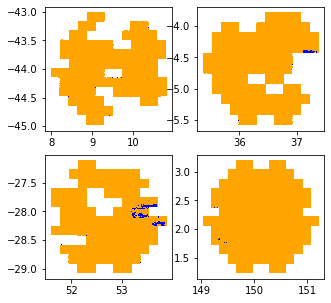

In [1]:
import numpy as np
import fitsio as fio
import pylab as plt
import pandas as pd
import astropy.table

#Y3 balrog detection file
balrog_detection_file = "/global/cfs/cdirs/des/severett/Balrog/run2a/stacked_catalogs/1.4/sof/balrog_detection_catalog_sof_run2a_v1.4.fits"

#Y3 balrog maglim sample file
balrog_maglim_file = "/global/cfs/cdirs/des/jelvinpo/cats/y3/balrog/run2/lens_samples_run2_v1.4/maglim_lens_v2p2_flux_balrog_run2_v1.4_masked.fits.gz"

#Y3 deep field magnitudes
deep_field_file = "/pscratch/sd/j/jelvinpo/DES/cats/y3/deepfields/Y3_DEEP_FIELDS_PHOTOM_ang_mag.fits"

#Y3 deep field star galaxy separator
deep_field_sg_file = "/pscratch/sd/j/jelvinpo/DES/cats/y3/deepfields/Y3_DEEP_FIELDS_PHOTOM_ang_mag_sg.fits"

#Y3 deep field matched to WISE forced photometry of Legacy Survey (from Noah)
deep_field_wise_file = "/global/cfs/projectdirs/des/nweaverd/y3_deepfields/dr10.0/south/matched/merged_ls-dr10.0-Y3_DEEP_FIELDS_PHOTOM_ang_mag.fits"


###############################
###### load the tables in pandas DataFrame
###############################

balrog_detection_table = astropy.table.Table.read(balrog_detection_file)
data = np.array([
    balrog_detection_table['true_id'],
    balrog_detection_table["true_bdf_mag_deredden"][:,0],
    balrog_detection_table["true_bdf_mag_deredden"][:,1],
    balrog_detection_table["true_bdf_mag_deredden"][:,2],
    balrog_detection_table["true_bdf_mag_deredden"][:,3],
    balrog_detection_table['detected'],
])
columns = [
    'true_id', 
    'true_bdf_mag_deredden_g',
    'true_bdf_mag_deredden_r',
    'true_bdf_mag_deredden_i',
    'true_bdf_mag_deredden_z',
    'detected',
]
balrog_detection = pd.DataFrame(data=data.T, columns=columns)

deep_field = astropy.table.Table.read(deep_field_file).to_pandas()
deep_field_sg = astropy.table.Table.read(deep_field_sg_file).to_pandas()
deep_field_wise_table = astropy.table.Table.read(deep_field_wise_file)
names = [name for name in deep_field_wise_table.colnames if len(deep_field_wise_table[name].shape) <= 1]
deep_field_wise = deep_field_wise_table[names].to_pandas()

balrog_maglim_fits = fio.read(balrog_maglim_file)
balrog_maglim = astropy.table.Table(data=[
    balrog_maglim_fits["true_id"],
    balrog_maglim_fits['meas_cm_mag_deredden'][:,1],
    balrog_maglim_fits['meas_cm_mag_deredden'][:,3],
    balrog_maglim_fits['Z_MEAN'],
    balrog_maglim_fits['true_bdf_T'],
    balrog_maglim_fits['true_bdf_T_err'],
    ],
    names=[
        'INJ_ID',
        'meas_cm_mag_deredden_r',
        'meas_cm_mag_deredden_z',
        'Z_MEAN',
        'true_bdf_T',
        'true_bdf_T_err',
    ],
    ).to_pandas()

###############################
###### match the catalogs 
###############################

n_deep = len(deep_field)
n_deep_sg = len(deep_field)
n_deep_wise = len(deep_field_wise)
assert n_deep == n_deep_sg

deep_field = deep_field.merge(
    deep_field_sg, 
    how='inner', 
    on='ID', 
)
assert len(deep_field) == n_deep
del deep_field_sg

deep_field_wise = deep_field_wise.merge(
    deep_field, 
    how='left', 
    on='ID', 
)
assert len(deep_field_wise) == n_deep_wise

balrog_detection_matched_deep = balrog_detection.merge(
    deep_field, 
    how='left', 
    left_on='true_id', 
    right_on='ID')
balrog_detection_matched_deep_wise = balrog_detection.merge(
    deep_field_wise, 
    how='left', 
    left_on='true_id', 
    right_on='ID')
is_match_det = ~np.isnan(np.array(balrog_detection_matched_deep_wise['ID']))

balrog_maglim_matched_deep = balrog_maglim.merge(
    deep_field, 
    how='left', 
    left_on='INJ_ID', 
    right_on='ID')
balrog_maglim_matched_deep_wise = balrog_maglim.merge(
    deep_field_wise, 
    how='left', 
    left_on='INJ_ID', 
    right_on='ID')
is_match_maglim = ~np.isnan(np.array(balrog_maglim_matched_deep_wise['ID']))

###############################
###### Count numbers
###############################

print("Fraction of balrog injections with deep field match (should be 1.0) =", 
      len(balrog_detection_matched_deep)/len(balrog_detection),
     )
print("Fraction of balrog injections with WISE match =", 
      len(balrog_detection_matched_deep_wise[is_match_det])/len(balrog_detection),
     )
print("Fraction of balrog detections with WISE match =", 
      np.sum(balrog_detection_matched_deep_wise['detected'][is_match_det])/np.sum(balrog_detection['detected']),
     )
print("Fraction of balrog-maglim with WISE match =", 
      len(balrog_maglim_matched_deep_wise[is_match_maglim])/len(balrog_maglim_matched_deep),
     )


###############################
###### Plot deep field ra/dec and matches
###############################

fig, axs = plt.subplots(2,2,figsize=(5,5))
axs = axs.flatten()
in_wise = np.in1d(deep_field['ID'],deep_field_wise['ID'])

ra  = np.array(deep_field['RA_x'])
dec = np.array(deep_field['DEC_x'])
select1 = (ra < 20)
select2 = (ra < 60)*(dec > -10)
select3 = (ra > 40)*(dec < -20)
select4 = (ra > 120)
select = [select1, select2, select3, select4,]
for i in range(4):
    axs[i].plot(ra[select[i]], dec[select[i]], ',', color='blue')
    axs[i].plot(ra[in_wise*select[i]], dec[in_wise*select[i]], ',', color='orange')

fig.savefig('deep_ra_dec.png')


###############################
###### get fractions objects in each KNN catagory
###############################
zminusw1 = np.array(balrog_maglim_matched_deep_wise["meas_cm_mag_deredden_z"])-np.array(balrog_maglim_matched_deep_wise["W1_MAG_CORR"])
rminusz  = np.array(balrog_maglim_matched_deep_wise["meas_cm_mag_deredden_r"])-np.array(balrog_maglim_matched_deep_wise["meas_cm_mag_deredden_z"])                                                                                         
z = np.array(balrog_maglim_matched_deep_wise["Z_MEAN"])
knn = np.array(balrog_maglim_matched_deep_wise['KNN_CLASS'])

cuts_y6 = [
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 0.8*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 2.5*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.4)*(zminusw1 < 2.5*(rminusz-0.75)-0.4), 
    (zminusw1 < 0.7*(rminusz-1.2)+0  )*(zminusw1 < 3*(rminusz-1.2)+0), 
    (zminusw1 < 0.7*(rminusz-1.4)+0.1)*(zminusw1 < 6*(rminusz-1.4)+0.1), 
    (zminusw1 < 0.7*(rminusz-1.6)+0.1)*(zminusw1 < 6*(rminusz-1.6)+0.1), 
]
cuts_y3 = [
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 0.8*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.5)*(zminusw1 < 0.8*(rminusz-0.75)-0.5), 
    (zminusw1 < 0.7*(rminusz-0.75)-0.4)*(zminusw1 < 2.5*(rminusz-0.75)-0.4), 
    (zminusw1 < 0.7*(rminusz-1.1)+0  )*(zminusw1 < 15*(rminusz-1.1)+0), 
    (zminusw1 < 0.7*(rminusz-1.35)+0.1)*(zminusw1 < 15*(rminusz-1.35)+0.1), 
    (zminusw1 < 0.7*(rminusz-1.6)+0.1)*(zminusw1 < 6*(rminusz-1.6)+0.1), 
]
cuts = cuts_y3

binedges = [0.2, 0.4, 0.55, 0.7, 0.85, 0.95, 1.05]

print('Fraction of Y3 balrog-maglim objects removed by WISE cut, binned by KNN Star/gal classifier')
print('')
print ("bin", "No_Class", "Galaxy", "Star", "Ambiguous")
for ibin in range(len(binedges)-1):
    selectz = (z > binedges[ibin])*(z < binedges[ibin+1])

    knn_bin_before = knn[selectz]
    knn_bin_after = knn[selectz*~cuts[ibin]]

    nc_before   = np.sum((knn_bin_before == 0).astype(int))
    gal_before  = np.sum((knn_bin_before == 1).astype(int))
    star_before = np.sum((knn_bin_before == 2).astype(int))
    amb_before  = np.sum((knn_bin_before == 3).astype(int))

    nc_after   = np.sum((knn_bin_after == 0).astype(int))
    gal_after  = np.sum((knn_bin_after == 1).astype(int))
    star_after = np.sum((knn_bin_after == 2).astype(int))
    amb_after  = np.sum((knn_bin_after == 3).astype(int))
    
    if amb_before == 0 and amb_after == 0:
        amb_x = 0.
    else:
        amb_x = np.round(1-amb_after/amb_before,3)
    
    print(
        str(ibin+1).ljust(3), 
        str(np.round(1-nc_after/nc_before,3)).ljust(8), 
        str(np.round(1-gal_after/gal_before,3)).ljust(6), 
        str(np.round(1-star_after/star_before,3)).ljust(5),
        str(amb_x).ljust(9),
        )
    
    
    
    
    

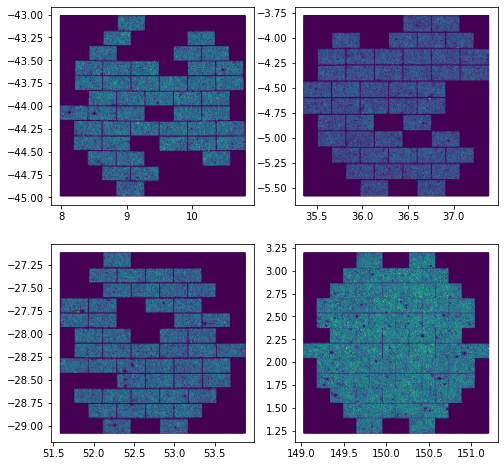

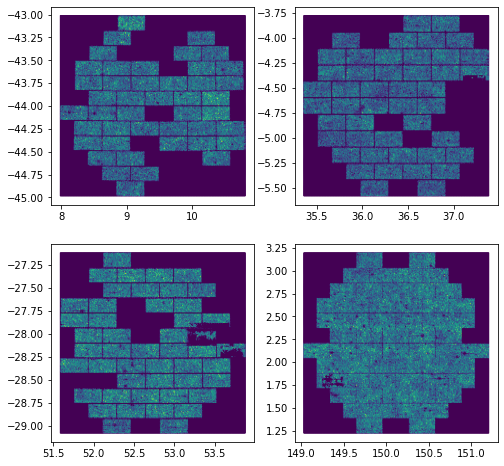

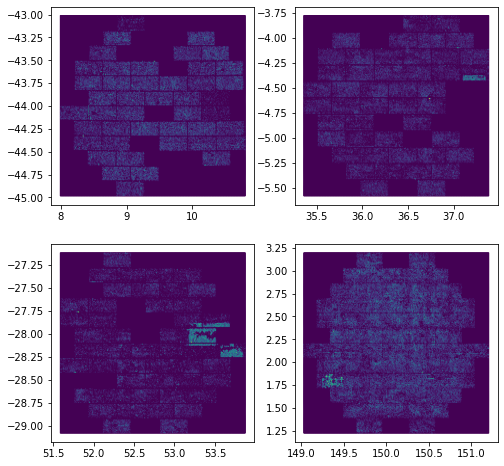

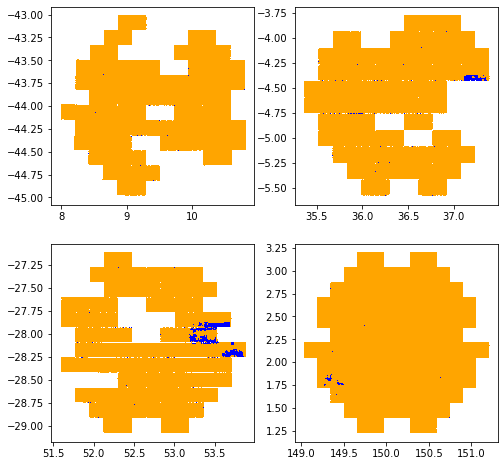

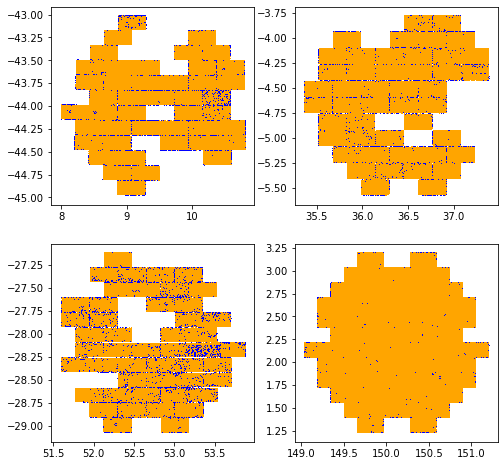

In [35]:

ra  = np.array(deep_field['RA_x'])
dec = np.array(deep_field['DEC_x'])
bright = (np.array(deep_field['BDF_MAG_DERED_I']) < 22)
select1 = (ra < 20)
select2 = (ra < 60)*(dec > -10)
select3 = (ra > 40)*(dec < -20)
select4 = (ra > 120)
select = [select1, select2, select3, select4,]
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()
for i in range(4):
    axs[i].hexbin(ra[select[i]], dec[select[i]], gridsize=300)
fig.savefig('deep_ra_dec_hex_all.png')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()
for i in range(4):
    axs[i].hexbin(ra[in_wise*select[i]], dec[in_wise*select[i]], gridsize=300)
fig.savefig('deep_ra_dec_hex_in.png')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()
for i in range(4):
    axs[i].hexbin(ra[~in_wise*select[i]], dec[~in_wise*select[i]], gridsize=300)
fig.savefig('deep_ra_dec_hex_out.png')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()
for i in range(4):
    axs[i].plot(ra[select[i]], dec[select[i]], ',', color='blue')
    axs[i].plot(ra[in_wise*select[i]], dec[in_wise*select[i]], ',', color='orange')
fig.savefig('deep_ra_dec_in_on_all.png')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()
for i in range(4):
    axs[i].plot(ra[select[i]], dec[select[i]], ',', color='blue')
    axs[i].plot(ra[~in_wise*select[i]], dec[~in_wise*select[i]], ',', color='orange')
fig.savefig('deep_ra_dec_out_on_all.png')